In [13]:
from Modules import wine_quantiles, wine_recommender, wine_transformations
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
import scipy.stats as stats

data = pd.read_csv("https://raw.githubusercontent.com/nicholas-rf/Vinter/main/clean_no_special_names.csv")
data.drop(inplace=True, columns=['Unnamed: 0'])
reds = data[data['type'] == 'red']
whites = data[data['type'] == 'white']

## Next Steps
Now that our single store database has been loaded into our notebook, we can start to explore our data by applying transformations. 

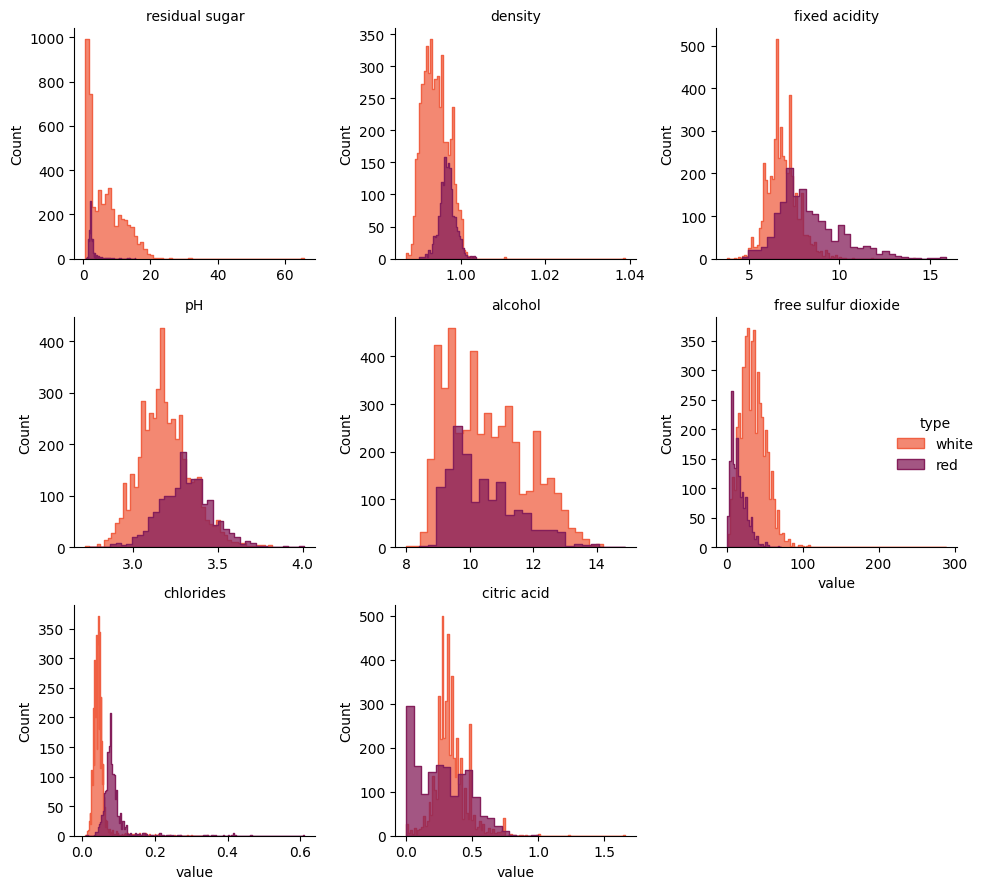

In [14]:
variables = ['residual sugar', 'density', 'fixed acidity', 'pH', 'alcohol', 'free sulfur dioxide', 'chlorides', 'citric acid']
wine_data_long = data.melt(id_vars='type', value_vars=variables, var_name='variable', value_name='value')

g = sns.FacetGrid(wine_data_long, col="variable", hue="type", palette="rocket_r", col_wrap=3, sharex=False, sharey=False)
g = (g.map(sns.histplot, "value", element="step").add_legend())

g.set_titles("{col_name}")
g.fig.tight_layout()

plt.show()

## Outlier removal
As noticeable in residual sugar, density, free sulfur dioxide, chlorides, and citric acid, many outliers are prevalent. For our data, we will now utilize two separate outlier removal techniques: IQR and Z score thresholds.

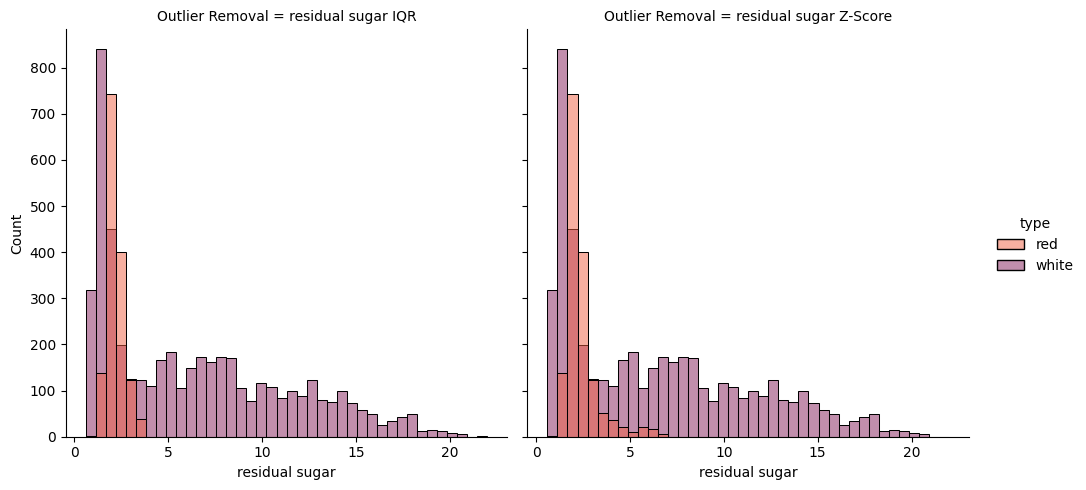

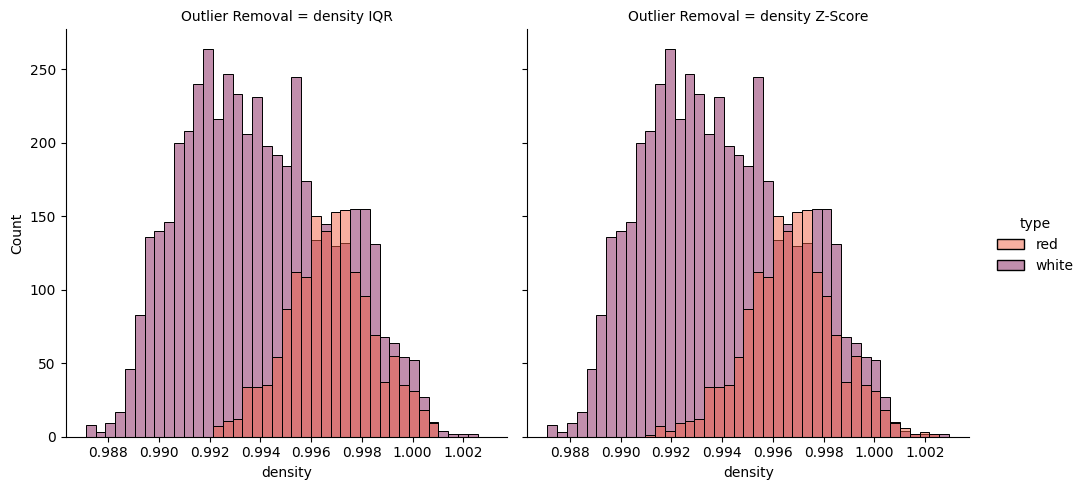

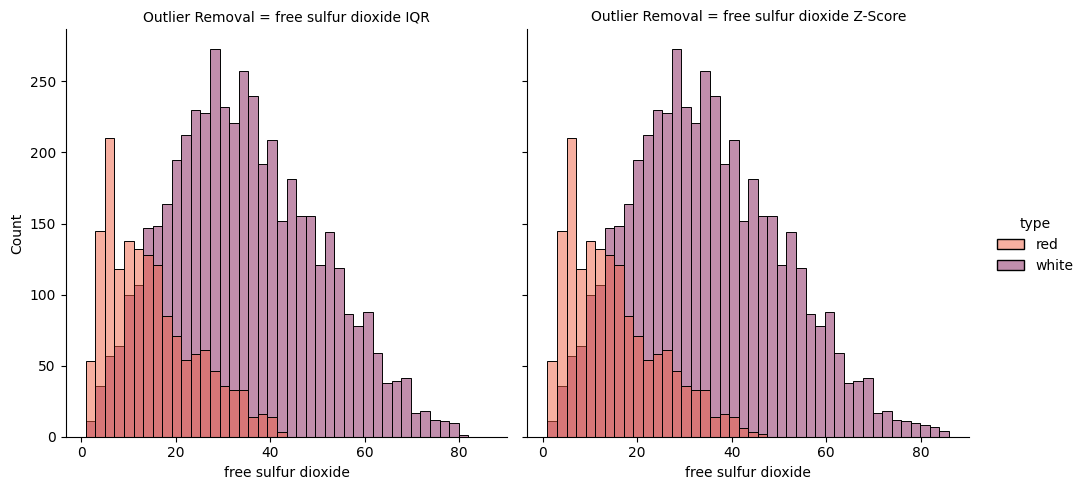

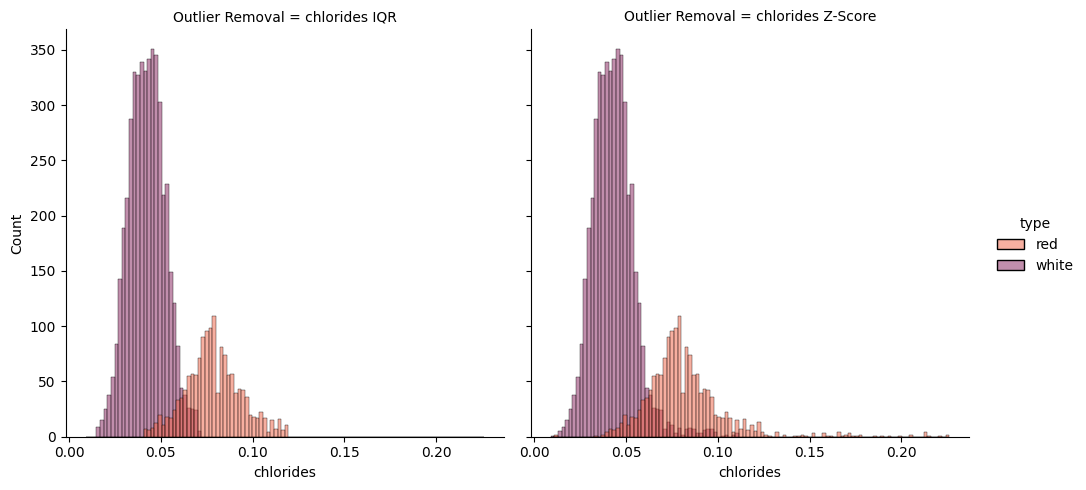

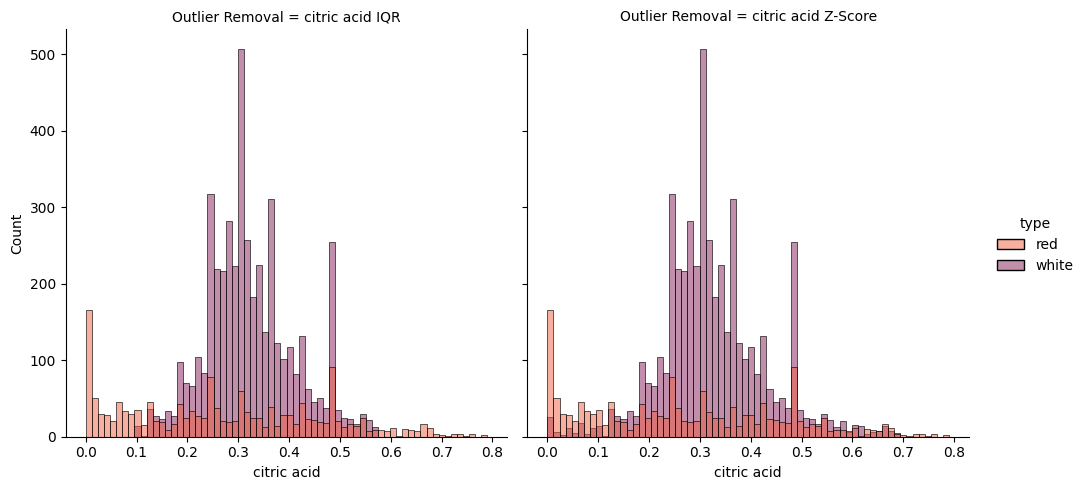

In [15]:
outlier_vars = ['residual sugar', 'density', 'free sulfur dioxide', 'chlorides', 'citric acid']
outlier_removal_types = ['IQR', 'Z-Score']
IQR = []
Z_SCORE = []
for i in range(5):
    feature = outlier_vars[i]
    IQR.append([wine_transformations.remove_outliers(reds, feature, True, 1.5), wine_transformations.remove_outliers(whites, feature, True, 1.5)])
    Z_SCORE.append([wine_transformations.remove_outliers(reds, feature, False, 3), wine_transformations.remove_outliers(whites, feature, False, 3)])
final_outputs = []
for index in range(5):
    final_outputs.append([pd.concat(IQR[index], axis=0), pd.concat(Z_SCORE[index], axis=0)])
for i in range(5):
    wine_transformations.map_affects(final_outputs[i], outlier_vars[i], outlier_removal_types, 'Outlier Removal')

## Interpreting Outlier Removal
We can tell from our charts that IQR outlier removal performed better, so we will apply it to our data.

In [16]:
for feature in outlier_vars:
    reds = wine_transformations.remove_outliers(reds, feature, True, 1.5)
    whites = wine_transformations.remove_outliers(whites, feature, True, 1.5)

## Normalization
In addition to outlier removal, we will be normalizing our variables of interest before applying any extra transformations or using them in interaction calculations. However, we will not be applying any transformations to fixed sulfur dioxide, as its value is used heavily in an interaction feature calculation.

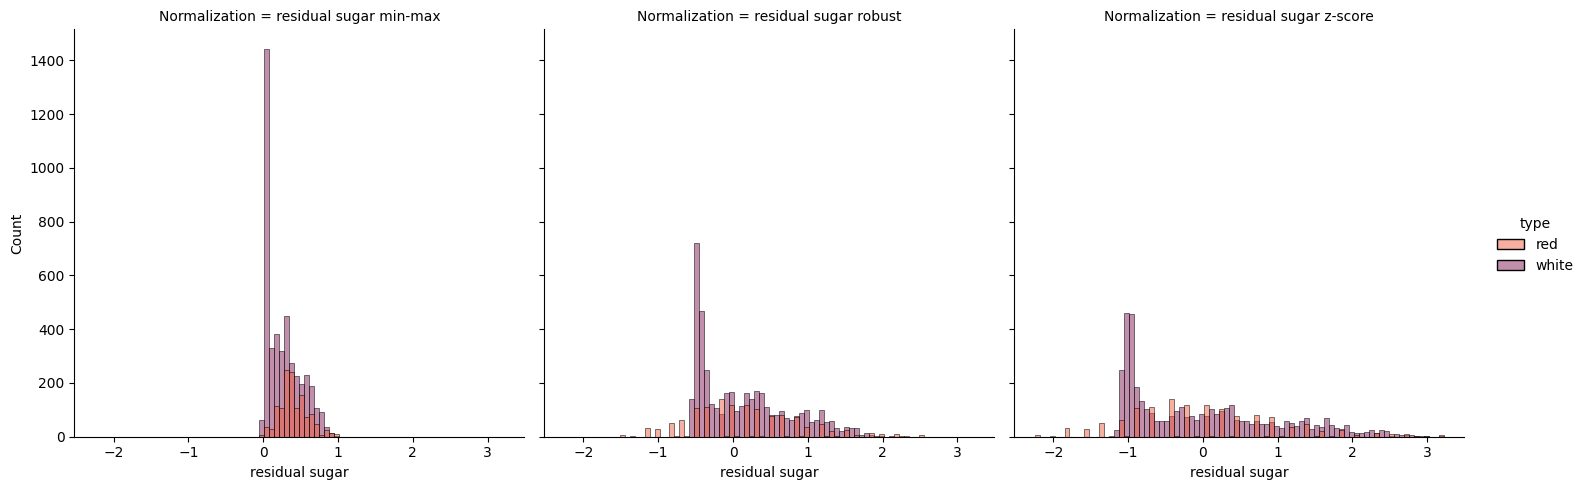

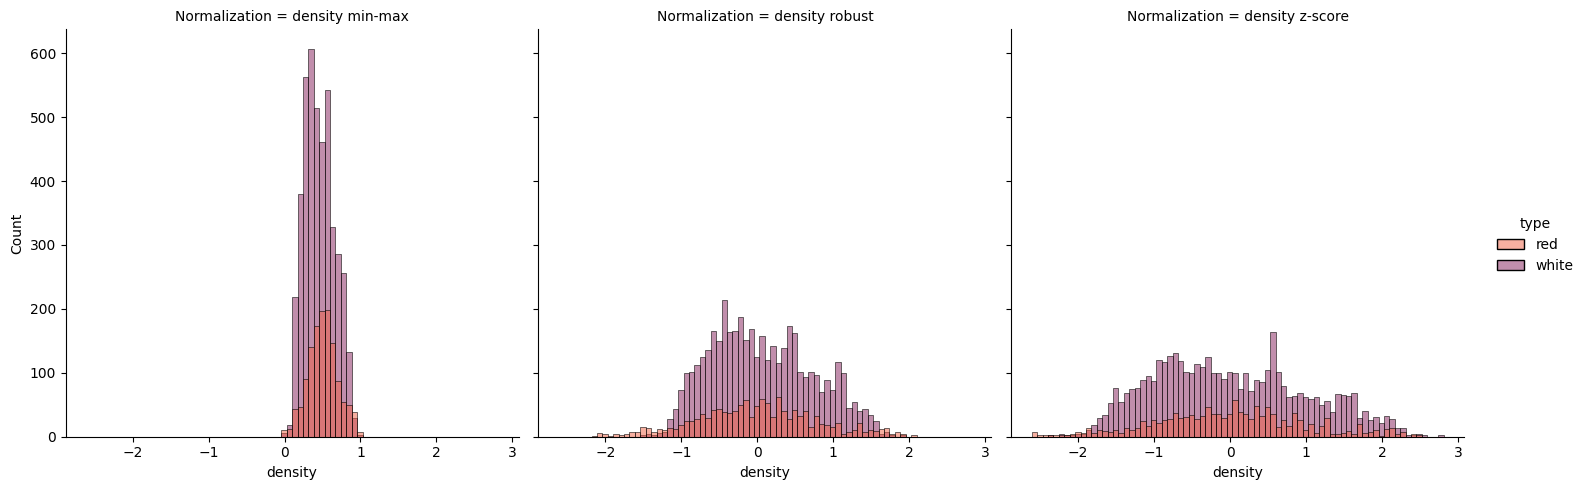

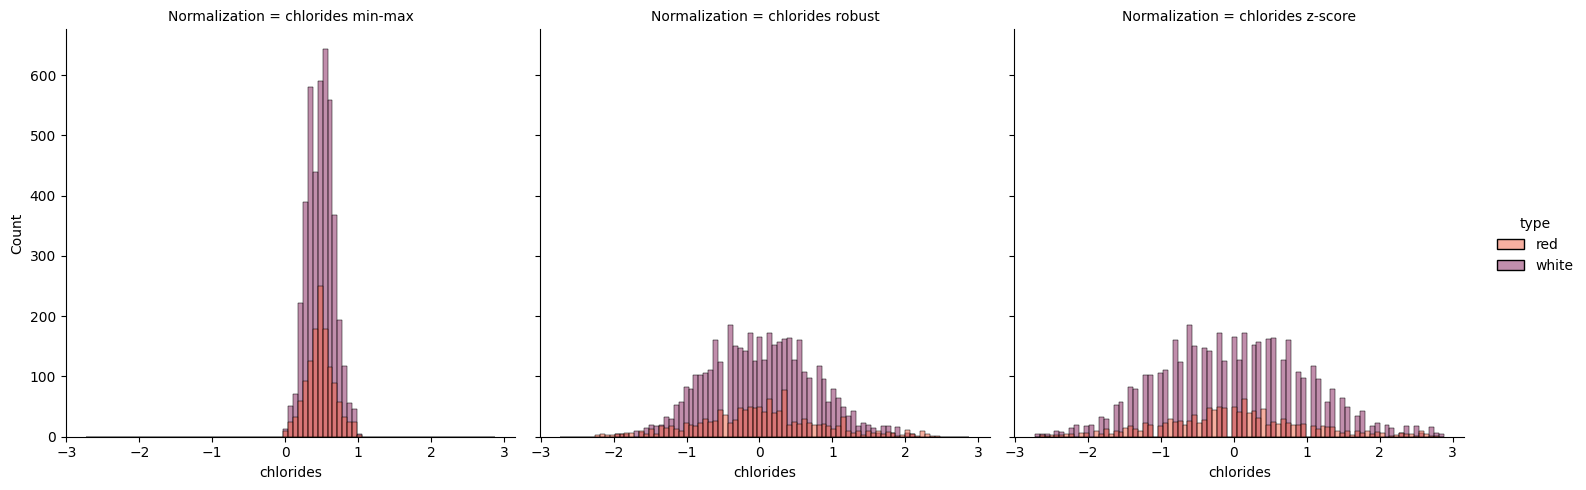

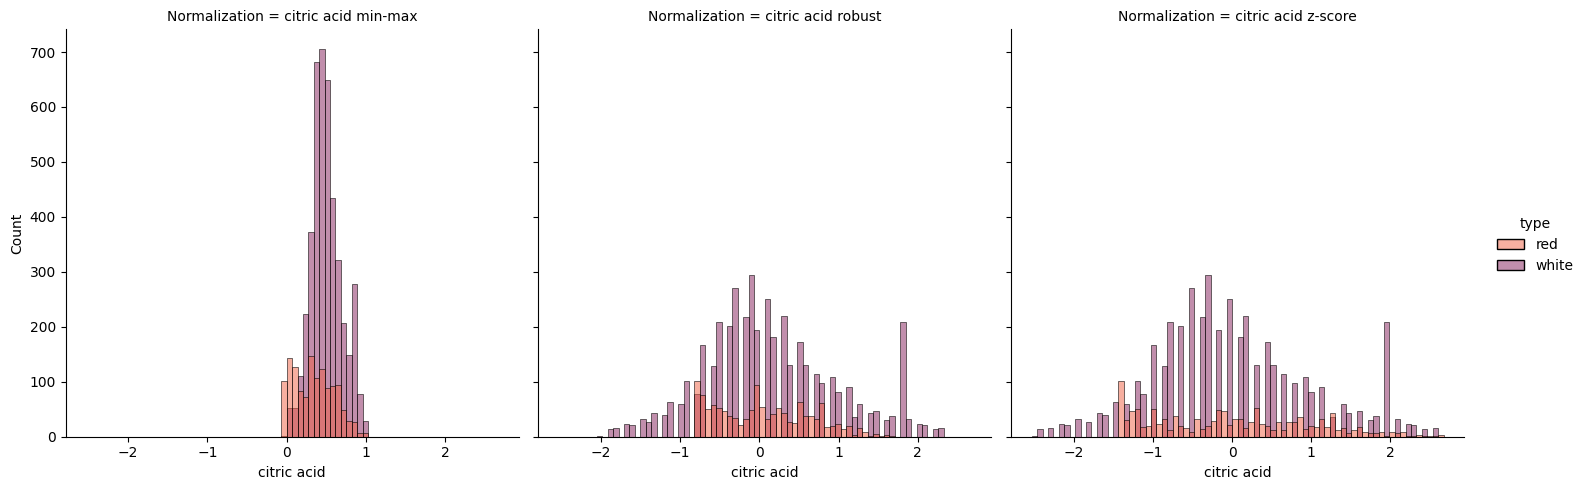

In [17]:
normalizer_var = ['residual sugar', 'density', 'chlorides', 'citric acid']
normalizer_types = ['min-max', 'robust', 'z-score']
MIN_MAX = []
ROBUST = []
Z_SCORE = []

for i in range(4):
    feature = normalizer_var[i]
    MIN_MAX.append([wine_transformations.apply_normalization_techniques(reds, feature, 'min-max'),
                    wine_transformations.apply_normalization_techniques(whites, feature, 'min-max')])
    ROBUST.append([wine_transformations.apply_normalization_techniques(reds, feature, 'robust'),
                   wine_transformations.apply_normalization_techniques(whites, feature, 'robust')])
    Z_SCORE.append([wine_transformations.apply_normalization_techniques(reds, feature, 'z-score'),
                    wine_transformations.apply_normalization_techniques(whites, feature, 'z-score')])

final_outputs=[]
for index in range(4):
    final_outputs.append([pd.concat(MIN_MAX[index], axis=0), pd.concat(ROBUST[index], axis=0), pd.concat(Z_SCORE[index], axis=0)])

for index in range(4):
    wine_transformations.map_affects(final_outputs[index], normalizer_var[index], normalizer_types, 'Normalization')  

## Interpreting normalization methods
Based off our charts, we have a clear choice between either a more even distribution or a more uniform one. Given that we are attempting to assign characteristics to wine based off of these distributions, its fair to say that each feature should be considered differently. For sugar we will use the robust normalization method as it features a broad distribution ensuring a wide range of possible values for sugar. Will use the same metric for the density. Since chloride is weighted lightly in the acidity calculation, a wide range of values is preferred, therefore we will use the robust normalization method. Similarly for citric acid, we will use the robust measurements.

In [18]:
normalizer_types = ['min-max', 'robust', 'z-score']
normalizer_var = ['residual sugar', 'density', 'chlorides', 'citric acid']

for feature in normalizer_var:
    reds = wine_transformations.apply_normalization_techniques(reds, feature, 'robust')
    whites = wine_transformations.apply_normalization_techniques(whites, feature, 'robust')

## Applying interactions
Now that we have successfully transformed our features of interest, we can move on to calculating our research-backed interactions.

In [19]:
wine_data = pd.concat([reds, whites], axis=0)
wine_data.head()
prior_cols = wine_data.columns
prior_cols = prior_cols[2:12]
wine_data['crispness'] = wine_data.apply(wine_transformations.crispness, axis=1)
wine_data['acidity'] = wine_data.apply(wine_transformations.acidity, axis=1)
wine_data['fruitiness'] = wine_data.apply(wine_transformations.fruitiness, axis=1)
wine_data['sweetness'] = wine_data.apply(wine_transformations.sweetness, axis=1)
wine_data['dryness'] = wine_data.apply(lambda x : 4 - x['sweetness'], axis = 1)
wine_data.drop(columns=prior_cols, inplace=True)
wine_data.head(2)

,Unnamed: 0.1,type,alcohol,quality,clean name,crispness,acidity,fruitiness,sweetness,dryness
4898,4898,red,9.4,5,'UYberto 2019',28.051613,-7.097029,-5.746218,0.212745,3.787255
4899,4899,red,9.8,5,'SFis dez CruequetPer 2021',29.651613,-4.059221,1.924878,1.900980,2.099020


In [65]:
features = ['crispness', 'acidity', 'fruitiness', 'sweetness', 'dryness']
reds = wine_data[wine_data['type'] == 'red']
whites = wine_data[wine_data['type'] == 'white']
final_output=[]
for feature in features:
    reds = wine_quantiles.assign_even_bin(reds, feature)
    whites = wine_quantiles.assign_even_bin(whites, feature)

final_output = pd.concat([reds, whites], axis=0)
final_output[['crispness','acidity', 'fruitiness', 'sweetness', 'dryness']] = final_output[['crispness', 'acidity', 'fruitiness', 'sweetness', 'dryness']].astype(int)
final_output.drop(inplace=True, columns=['Unnamed: 0.1'])
final_output.reset_index(inplace=True, drop=True)
final_output.reset_index(inplace=True)
final_output.head(2)

,index,type,alcohol,quality,clean name,crispness,acidity,fruitiness,sweetness,dryness
0,0,red,9.4,5,'UYberto 2019',2,2,1,3,3
1,1,red,9.8,5,'SFis dez CruequetPer 2021',2,2,2,4,2


In [47]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 29.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=32c02254f9c9be4d1aa6d65e8b49956a42aad3829851fcdc33a8264e37bf4bd4
  Stored in directory: /home/jovyan/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark


In [50]:
final_output.rename(columns = {"index" : "wine_index","type" : "type_", "clean name" : "name_"}, inplace=True)
final_output.to_csv('/Users/nick/Desktop/final_dataset.csv')

OperationalError: (pymysql.err.OperationalError) (1364, "Field 'wine_index' doesn't have a default value")
[SQL: INSERT INTO wine_info (type_, alcohol, quality, name_, crispness, acidity, fruitiness, sweetness, dryness) VALUES (%(type_)s, %(alcohol)s, %(quality)s, %(name_)s, %(crispness)s, %(acidity)s, %(fruitiness)s, %(sweetness)s, %(dryness)s)]
[parameters: [{'type_': 'red', 'alcohol': 9.4, 'quality': 5, 'name_': "'UYberto 2019'", 'crispness': 2, 'acidity': 2, 'fruitiness': 1, 'sweetness': 3, 'dryness': 3}, {'type_': 'red', 'alcohol': 9.8, 'quality': 5, 'name_': "'SFis dez CruequetPer 2021'", 'crispness': 2, 'acidity': 2, 'fruitiness': 2, 'sweetness': 4, 'dryness': 2}, {'type_': 'red', 'alcohol': 9.8, 'quality': 5, 'name_': "'Rve Les Apechios IIk Garo Granim GOC'", 'crispness': 2, 'acidity': 2, 'fruitiness': 1, 'sweetness': 3, 'dryness': 3}, {'type_': 'red', 'alcohol': 9.8, 'quality': 6, 'name_': "'OOV'", 'crispness': 4, 'acidity': 4, 'fruitiness': 2, 'sweetness': 3, 'dryness': 3}, {'type_': 'red', 'alcohol': 9.4, 'quality': 5, 'name_': "'QA'", 'crispness': 2, 'acidity': 2, 'fruitiness': 1, 'sweetness': 3, 'dryness': 3}, {'type_': 'red', 'alcohol': 9.4, 'quality': 5, 'name_': "'Nion 2017'", 'crispness': 2, 'acidity': 2, 'fruitiness': 1, 'sweetness': 3, 'dryness': 3}, {'type_': 'red', 'alcohol': 9.4, 'quality': 5, 'name_': "'QA'", 'crispness': 2, 'acidity': 2, 'fruitiness': 1, 'sweetness': 3, 'dryness': 3}, {'type_': 'red', 'alcohol': 10.0, 'quality': 7, 'name_': "'GNoir 2019'", 'crispness': 2, 'acidity': 2, 'fruitiness': 1, 'sweetness': 2, 'dryness': 4}  ... displaying 10 of 5641 total bound parameter sets ...  {'type_': 'white', 'alcohol': 12.8, 'quality': 7, 'name_': "'Yrybaiss White'", 'crispness': 1, 'acidity': 1, 'fruitiness': 1, 'sweetness': 1, 'dryness': 5}, {'type_': 'white', 'alcohol': 11.8, 'quality': 6, 'name_': "'Ay Trosfand Vine'", 'crispness': 2, 'acidity': 1, 'fruitiness': 1, 'sweetness': 1, 'dryness': 5}]]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [243]:
!java -version

/bin/bash: line 1: java: command not found
